In [36]:
# Load the libraries as required.

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import shap
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import warnings

In [37]:
############################## LOAD PICKLE BELOW #################################

############### Load train data with numerical encoding ###############
# To load the data
with open("../../../data/train_data.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# Access the data
loaded_X_train_num_encoded = loaded_data["X_train"]
loaded_y_train_num_encoded = loaded_data["y_train_num_encoded"]

### Load train data with one hot encoding ###
# To load the data
with open("../../../data/train_data_hot_encoded.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# Access the data
loaded_X_train_hot_encoded = loaded_data["X_train"]
loaded_y_train_hot_encoded = loaded_data["y_train_hot_encoded"]

############### Load test data with numerical encoding ###############
# To load the data
with open("../../../data/test_data.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# Access the data
loaded_X_test_num_encoded = loaded_data["X_test"]
loaded_y_test_num_encoded = loaded_data["y_test_num_encoded"]

### Load train data with one hot encoding ###
# To load the data
with open("../../../data/test_data_hot_encoded.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# Access the data
loaded_X_test_hot_encoded = loaded_data["X_test"]
loaded_y_test_hot_encoded = loaded_data["y_test_hot_encoded"]

In [38]:
############################## GET PICKLE FILE TO BEST PRACTICE NAMING BELOW #################################

X_train = loaded_X_train_num_encoded
y_train = loaded_y_train_num_encoded
X_test = loaded_X_test_num_encoded
y_test = loaded_y_test_num_encoded

In [39]:
############################## PREPROCESS BELOW #################################

# Preprocess
preproc1 = ColumnTransformer([
    ('imputer', SimpleImputer(strategy='most_frequent'), X_train.columns),  # Impute missing values for all columns
], remainder='passthrough')

In [40]:
############################## PIPELINE A: LINEAR REGRESSION BELOW #################################

# Define pipeline
Pipeline_A = Pipeline([
    ('preprocessing', preproc1),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif, k=20)),  # Select top 20 important features
    ('regressor', LinearRegression())  # Use Linear Regression
])

Pipeline_A

# Fit the pipeline
Pipeline_A.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'pus_filled_pimples', 'blackheads', 'scurring', 'skin_peeling',
       'silver_like_dusting', 'small_dents_in_nails', 'inflammatory_nails',
       'blister', 'red_sore_around_nose', 'yellow_crust_ooze'],
      dtype='object', length=132))])),
                ('feature_selection',
                 SelectKBest(k=20,
                             score_func=<function mutual_info_classif at 0x000001CFAE459DC0>)),
                ('regressor', LinearRegression())])

In [41]:
############################## PREDICTIONS PIPELINE A: LINEAR REGRESSION BELOW #################################

# Load the training and testing datasets so can retrieve back to the original labels
training_file = "../../../data/raw/Training.csv"
testing_file = "../../../data/raw/Testing.csv"
disease_training = pd.read_csv(training_file)
disease_testing = pd.read_csv(testing_file)

# Get Y (target column)
y_train = disease_training['prognosis']
y_test = disease_testing['prognosis']

# Make predictions
y_pred = Pipeline_A.predict(X_test)

# Decode predictions back to original labels
label_num_encoder = LabelEncoder()
y_test_num_encoded = label_num_encoder.fit_transform(y_test)  # Convert to integers
y_pred_labels = label_num_encoder.inverse_transform(y_pred.round().astype(int))

print("Predicted labels:", y_pred_labels)


Predicted labels: ['Drug Reaction' 'Hepatitis B' 'GERD' 'Diabetes ' 'Drug Reaction'
 'Hyperthyroidism' 'Drug Reaction' 'Hepatitis C' 'Hepatitis E'
 'Gastroenteritis' 'Hypoglycemia' 'Hepatitis D' 'Fungal infection'
 'Hepatitis C' 'Hepatitis B' 'Impetigo' 'Drug Reaction' 'GERD'
 'Osteoarthristis' 'Paralysis (brain hemorrhage)' 'Hepatitis C' 'Dengue'
 'Osteoarthristis' 'Malaria' 'Dimorphic hemmorhoids(piles)'
 'Paralysis (brain hemorrhage)' 'Heart attack' 'Hepatitis E'
 'Fungal infection' 'Impetigo' 'Hepatitis C' 'Hepatitis C' 'Typhoid'
 'Hypertension ' 'Hypothyroidism' 'Fungal infection' 'Common Cold'
 'Fungal infection' 'Fungal infection' 'Hypoglycemia' 'Drug Reaction'
 'Drug Reaction']


In [42]:
############################## TEST ACCURACY PIPELINE A: LINEAR REGRESSION BELOW #################################

# Predict on the test set
y_pred = Pipeline_A.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test_num_encoded, y_pred)
mae = mean_absolute_error(y_test_num_encoded, y_pred)
r2 = r2_score(y_test_num_encoded, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 85.8381
Mean Absolute Error: 7.8263
R^2 Score: 0.3746


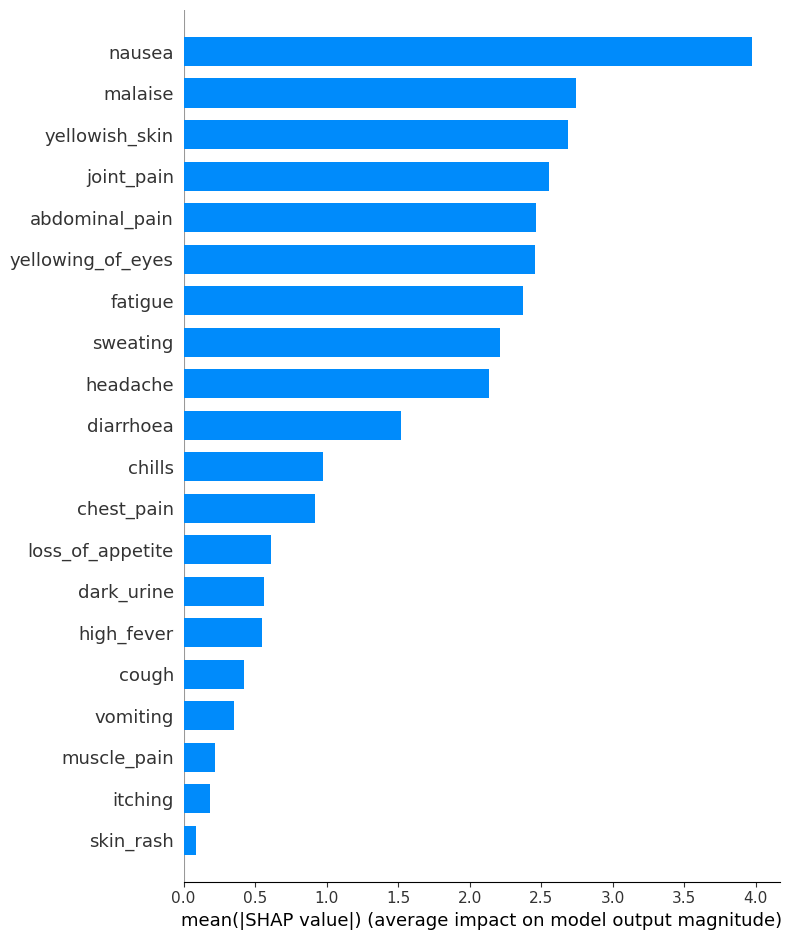

In [43]:
############################## SHAP TEST PIPELINE A: LINEAR REGRESSION BELOW #################################
#### High SHAP values indicate significant contributions of features to predictions. #####

# Extract the trained model after the pipeline steps
trained_model = Pipeline_A.named_steps['regressor']  # Linear regression model
feature_selector = Pipeline_A.named_steps['feature_selection']  # Feature selection step

# Select the features used in training
selected_features = feature_selector.get_support(indices=True)
X_test_selected = X_test.iloc[:, selected_features]

# Initialize SHAP explainer
explainer = shap.LinearExplainer(trained_model, X_test_selected)

# Generate SHAP values
shap_values = explainer.shap_values(X_test_selected)

# Visualize feature importance for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test_selected.iloc[0, :])

# Summary plot for global interpretability
shap.summary_plot(shap_values, X_test_selected, plot_type='bar')
